In [65]:
from qiskit import QuantumCircuit
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram
from qiskit.primitives import BackendSampler
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt

In [66]:
testing_angle = 9*pi/8

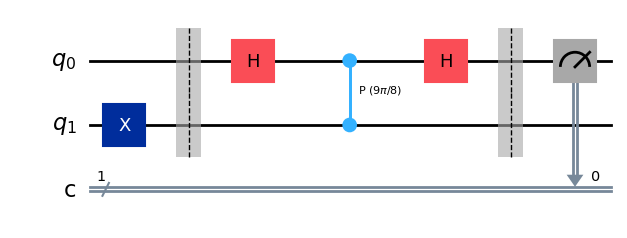

In [67]:
qc = QuantumCircuit(2,1)
qc.x(1)
qc.barrier()
qc.h(0)
qc.cp(testing_angle,0,1)
qc.h(0)
qc.barrier()
qc.measure(0,0)
qc.draw("mpl")

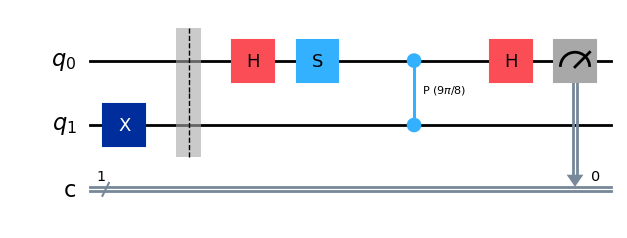

In [68]:
qc2 = QuantumCircuit(2,1)
qc2.x(1)
qc2.barrier()
qc2.h(0)
qc2.s(0)
qc2.cp(testing_angle,0,1)
qc2.h(0)
qc2.measure(0,0)
qc2.draw("mpl")

In [76]:
backend = BasicSimulator()

num_of_shots = 10000000

result = backend.run(qc, shots=num_of_shots).result()   
counts = result.get_counts()                    

result2 = backend.run(qc2, shots=num_of_shots).result()   
counts2 = result2.get_counts()                

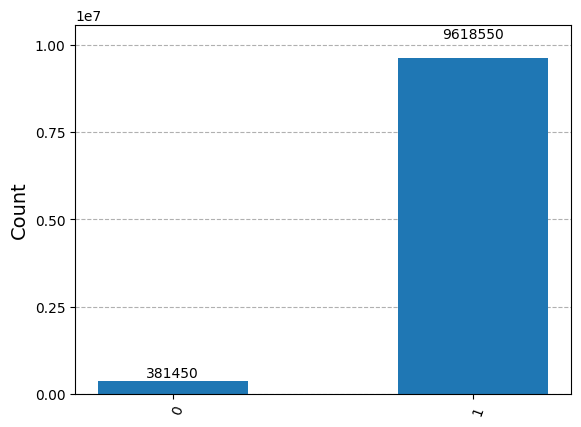

In [70]:
plot_histogram(counts)

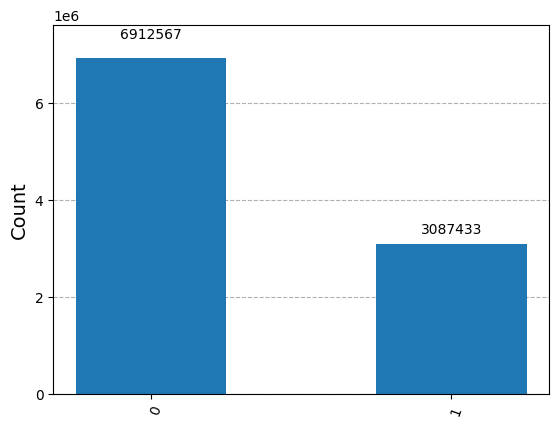

In [71]:
plot_histogram(counts2)

In [72]:
print("Results of the Trial: ", counts)
re = 1-(2*counts['1']/num_of_shots)
im = (2*counts2['1']/num_of_shots)-1
phi1 = np.arccos(re)/(2*pi)
phi2 = np.arcsin(im)/(2*pi)
print("Phi 1: ", phi1, "\nPhi 2: ", phi2)
print("What we got: ", phi1)
print("What we want: ", testing_angle / (2*pi))

Results of the Trial:  {'1': 9618550, '0': 381450}
Phi 1:  0.4374295304621712 
Phi 2:  -0.06247070996901087
What we got:  0.4374295304621712
What we want:  0.5625


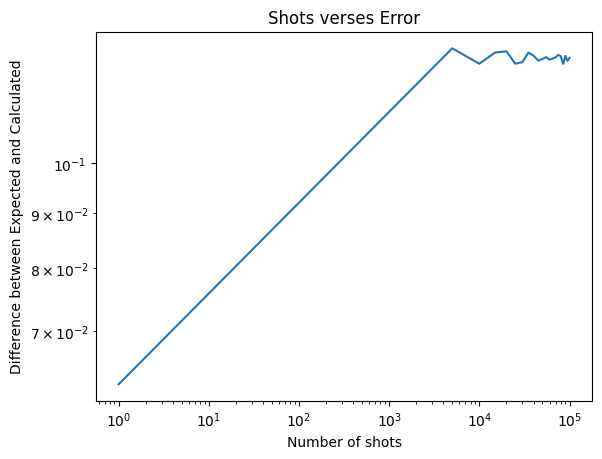

In [87]:
# Construct a graph of error verses number of shots
backend = BasicSimulator()

trials = np.linspace(1, 10**5, 21)
error_diff = []
expected_phi = testing_angle / (2*pi)
for num_of_shots in trials:
    # for some reason python doesn't believe I made it an int
    num_of_shots = int(num_of_shots)
    counts = backend.run(qc, shots=num_of_shots).result().get_counts()   
    re = 1-(2*counts['1']/num_of_shots)
    phi = np.arccos(re)/(2*pi)
    error_diff.append( abs(phi-expected_phi) )
plt.plot(trials, error_diff)
plt.title("Shots verses Error")
plt.xlabel("Number of shots")
plt.ylabel("Difference between Expected and Calculated")
plt.xscale("log")
plt.yscale("log")
plt.show()